In [81]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from mechanics import *
from data_reading import *
import progressbar

In [82]:
mode = "chaos"

"""
    Reads in necessary parameters from config.ini
"""

print("Preparing data...")
N,size,[] = read_config([])

print("Reading data...")
x_temp = read_vector("../data/SpringMassModel/x.csv",(N,2,size+1,size+1))
x_cm_temp = read_vector("../data/SpringMassModel/x_cm.csv",(N,2,size+1,size+1))
T = read_scalar("../data/SpringMassModel/T.csv",(1,N,size,size))[0]
f = read_vector("../data/SpringMassModel/f.csv",(N,2,size+1,size+1))

Preparing data...
Reading data...
shape of data:  (1000, 2, 101, 101)


100% |########################################################################|


shape of data:  (1000, 2, 101, 101)


100% |########################################################################|


shape of data:  (1, 1000, 100, 100)


100% |########################################################################|


shape of data:  (1000, 2, 101, 101)


100% |########################################################################|


In [83]:
def define_system(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    l_p_min, l_p_max = kwargs_sys['l_p_min'], kwargs_sys['l_p_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']

    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    l_a_arr = kwargs_sys['l_a']
    t_interp = kwargs_sys['t_interp']

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        l_p = l_p_min + (l_p_max - l_p_min) * np.random.rand()

        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'l_p':l_p,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta':eta}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_4p(x_cm_arr,t_interp,t)
        x_j = t_to_value_4p(x_j_arr,t_interp,t)
        l_a = t_to_value_1p(l_a_arr,t_interp,t)

        #initialize total force
        f = total_force(x, x_j, x_cm, l_a, t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2)

    return eom, loss, gen_params, gen_y0, {}

In [84]:
N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
l_a0,l_p0,l_g0 = ((eta0-1/2)**2+1/2**2)**(1/2), ((eta0-1/2)**2+1/2**2)**(1/2), l_0


real_params = {'l_a':l_a0,'l_p':l_p0,'l_g':l_g0,'c_a':c_a,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta':eta0}

delta_t = delta_t_m * it_m
t_evals = jnp.linspace(0,N*delta_t,N)
N_interp = int(it_m)*10

x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp, x_cm_temp,T,50,50,real_params['l_a']) # i and j specify the cell taken from the grid 
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
l_a_interp = l_a
t_interp, l_a_interp = interpolate_scalar(l_a,t_evals,N_interp)

y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}
l_a0

0.5

## Check grid positions


In [85]:
qa = interpolate_q_a(x_j[:,0,:],x_i[0,:],.2)
qp = interpolate_q_p(x_j[:,0,:],x_i[0,:],.2)
type(qa)

jaxlib.xla_extension.ArrayImpl

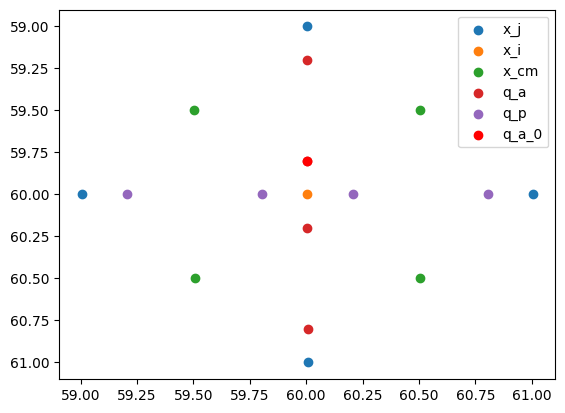

In [86]:
plt.scatter(x_j[:,0,0],x_j[:,0,1],label='x_j')
plt.scatter(x_i[0,0],x_i[0,1],label='x_i')
plt.scatter(x_cm[:,0,0],x_cm[:,0,1],label='x_cm')
plt.scatter(qa[:,0],qa[:,1],label='q_a')
plt.scatter(qp[:,0],qp[:,1],label='q_p')
plt.scatter(qa[0,0],qa[0,1],label='q_a_0',color='red')
# plt.scatter(x_j[0,0,0],x_j[0,0,1],label='x_j_0',color='red')
# plt.scatter(x_cm[0,0,0],x_cm[0,0,1],label='x_cm_1',color='red')
plt.gca().invert_yaxis()
plt.legend()

## Test of eom


In [87]:
total_force(x_i[0],x_j[:,0,:],x_cm[:,0,:],l_a[:,0],t_evals[0],real_params)
f_data_eom = np.zeros((N,2))
for i in range(N):
    f_data_eom[i] = total_force(x_i[i],x_j[:,i,:],x_cm[:,i,:],l_a[:,i],t_evals[i],real_params)



### Test force


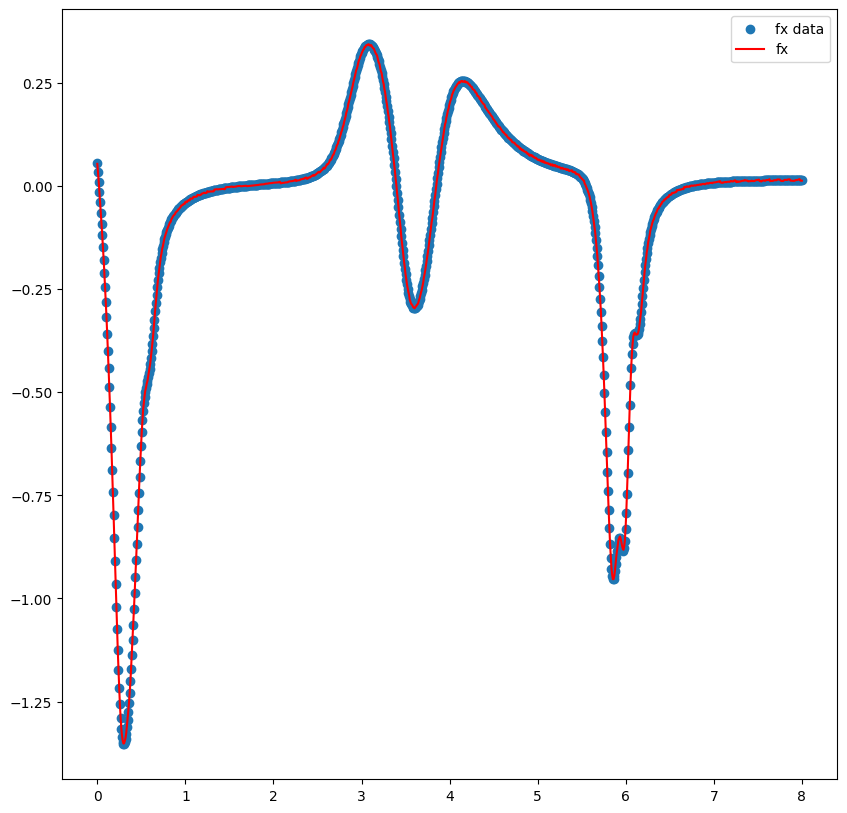

In [88]:
fig = plt.figure(figsize=(10,10))
#plt.plot(t_evals,f_data_eom[:,0],label='x from data, f from eom')
plt.scatter(t_evals,f[:,0,50,50],label='fx data')
#plt.plot(t_evals,f[:,1,50,50],label='y data')

plt.plot(t_evals,f_data_eom[:,0],label='fx',color='red')
#plt.plot(t_evals,f_data_eom[:,1],label='y')
#plt.plot(t_list, f_x_list,label='f_list')

plt.legend()
plt.show()

### Test Trajectory

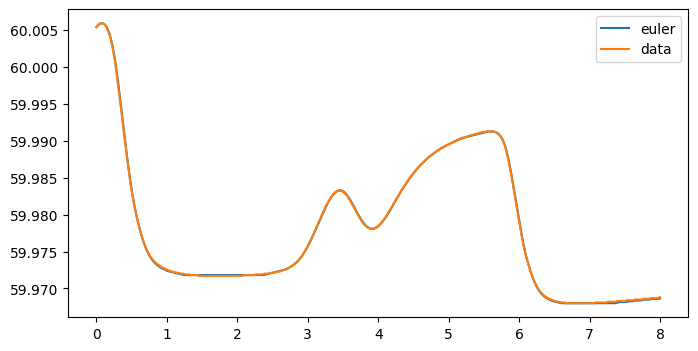

In [89]:
#create one plot of plot 1 and plot 2
x_list,t_list,f_x_list = euler(y0,N*5,real_params,x_cm_interp,x_j_interp,l_a_interp,t_interp,delta_t_m)
plt.figure(figsize=(8,4))
# plot 1
plt.plot(t_list[:],x_list[:],label = 'euler')
plt.plot(t_evals[:],x_i[:,0],label = 'data')
plt.legend()


17.014006 -0.95892423


In [210]:
from interpax import CubicSpline

In [226]:
# write a function that returns the corresponding value of a cubic spline at a given time. the cubic spline is defined on the time interval t_evals
fq = interpax.CubicSpline(t_evals, l_a[0,:])


test = CubicSpline.construct_fast(fq.c,t_evals)
test(5)


Array([0.49536982], dtype=float32)

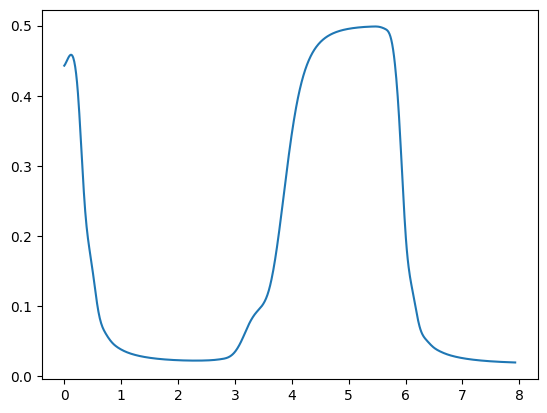

In [277]:


plt.plot(t_evals,test_short(t_evals),label='l_a')

In [333]:
#write a function, that gives every tenth value of an array

def every_tenth(arr):
    return arr[::15]   

t_short = every_tenth(t_evals)
l_short = every_tenth(l_a[0,:])

fq_short = interpax.CubicSpline(t_short, l_short)

test_short = CubicSpline.construct_fast(fq_short.c,t_short)


In [334]:
from functools import partial

In [342]:
# Function to generate a dictionary of all elements of fq_short.c
def c_to_dict(c):
    d = {}
    keys = []
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            d['c'+str(i)+'_'+str(j)] = c[i, j]
            keys.append('c'+str(i)+'_'+str(j))
    return d, keys

@jit
def dict_to_c(d, c_old):
    c = jnp.zeros(c_old.shape)
    for i in range(c_old.shape[0]):
        for j in range(c_old.shape[1]):
            c = c.at[i, j].set(d['c'+str(i)+'_'+str(j)])
    return c


# Generate dictionary and keys
c_la0, keys = c_to_dict(fq_short.c)

# Convert dictionary back to JAX array
c_new = dict_to_c(c_la0, fq_short.c)

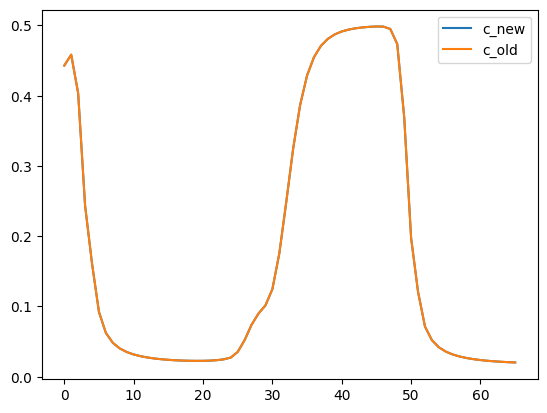

In [343]:
plt.plot(c_new[3,:],label = 'c_new')
plt.plot(fq_short.c[3,:],label = 'c_old')
plt.legend()
